# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)        
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)



<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [4]:
import os.path
import os
import numpy as np
from q3dfit.common import questfit_readcf

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [5]:
# book-keeping variables (unique to the user)
# Input files
volume = '../../../MIRISIM/MIRI-ETC-SIM/' # base directory
infile = volume+'miri_etc_cube.fits' # path + name of your input cube

# Output directories/files
outdir = volume+'outputs/' # path + name of directory for saving the output files
logfile = outdir+'miritest_fitlog.txt' # path to output logfile
path_to_npy_file = outdir # path for initproc.npy



Some general information about your cube:

In [6]:
ncols = 16
nrows = 25
platescale = 0.3

fitrange = [11.53050463,13.47485667] # in micron

if not os.path.isfile(infile): print('Data cube not found.')

CUBE: WMAP extension does not exist.


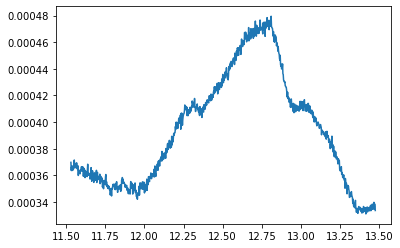

In [7]:
### more MIR settings
#   These are unique to the user
global_ice_model = 'ice_hc'
global_ext_model = 'CHIAR06'
cffilename = '../test/test_questfit/miritest.cf'
config_file = questfit_readcf.readcf(cffilename)
# Point to QSO template below. If this does not yet exist, it will be generated from the cube.
qsotemplate = '../data/questfit_templates/miri_qsotemplate.npy'
if not os.path.exists(qsotemplate):
    from q3dfit.common.makeqsotemplate import makeqsotemplate
    makeqsotemplate(infile, qsotemplate, dataext=1, varext=2, dqext=3, waveext=None)    

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [8]:
lines = ['[NeII]12.81']

How many components do you want to be fitted to the emission lines?

In [9]:
maxncomp = 1

In [10]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = '[NeII]12.81'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.)
    siginit_gas[i] = np.full(maxncomp, 500.) #0.1) #1000.)
    zinit_stars=np.full((ncols,nrows),0.0)    
    

# Parameters for emission line plotting
linoth = np.full((1, 1), '', dtype=object)
linoth[0, 0] = '[[NeII]12.81'
argspltlin1 = {'nx': 1,
                'ny': 1,
                'label': ['test-MIRLINE'],
                'wave': [128130.0],
                'off': [[-120,90]],
                'linoth': linoth}



# Velocity dispersion limits and fixed values
siglim_gas = np.ndarray(2)
siglim_gas[:] = [5, 1000]


#
# Output structure
#

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [11]:
initproc = { \
            # Required pars
            'fcninitpar': 'parinit',#gmos
            'fitran': fitrange,
            'fluxunits': 1,  # erg/s/cm^2/sr
            'infile': infile,
            'label': config_file['source'][0].replace('.ideos','').replace('.npy', ''),
            'lines': lines,
            'linetie': linetie,
            'maxncomp': maxncomp,
            'name': 'PG1411+442',
            'ncomp': ncomp,
            #'mapdir': mapdir,
            'outdir': outdir,

            'platescale': platescale,
            'positionangle': 335,
            'minoraxispa': 75,
            'zinit_stars': zinit_stars,
            'zinit_gas': zinit_gas,
            'zsys_gas': 0.0,
            # Optional pars
            'argscontfit': {'config_file': cffilename,
                            'global_ice_model': global_ice_model,
                            'global_ext_model': global_ext_model,
                            'models_dictionary': {},
                            'template_dictionary': {} },

            'argscontplot': {'xstyle':'log',
                             'ystyle':'log',
                             'mode':'dark'},

            'argslinelist': {'vacuum': False},
            'argspltlin1': argspltlin1,
            'decompose_qso_fit': 1,
            'fcncheckcomp': 'checkcomp',
            'fcncontfit': 'questfit',
            'maskwidths_def': 2000,
            'emlsigcut': 2,
            'logfile': logfile,
            #'batchfile': batchfile,
            #'batchdir': batchdir,
            'siglim_gas': siglim_gas,
            'siginit_gas': siginit_gas,
            'siginit_stars': 50,
            'nocvdf': 1,
            'plotMIR': True,
            'qsoonly':1,
            'argsreadcube': {'fluxunit_in': 'Jy',
                            'waveunit_in': 'angstrom',
                            'waveunit_out': 'micron'}        
            }

If you want to run `q3dfit` in batch mode, run this cell, which saves initproc to an `npy` file. In your python command line, read in that `npy` file with
<pre><code>import numpy as np
initproc = np.load('path/to/the/npy/file/initproc.npy',allow_pickle=True)</code></pre>
and then run `q3dfit` with 
<pre><code>from q3dfit.common.q3df
import q3df q3df(initproc[()],cols=cols,rows=rows)</code></pre>

In [12]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [13]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [14]:
cols = [7]
rows = [14]

Line(s)      name   
-----------
[NeII]12.81  outside of Morton validity for conversion to air
FITLOOP: First call to FITSPEC
1.0
1
FITSPEC: Continuum fit took 0.1 s.
[[Model]]
    Model(manygauss, prefix='lbNeIIrb12pt81_0_')
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 12
    # data points      = 906
    # variables        = 3
    chi-square         = 518923.542
    reduced chi-square = 574.666159
    Akaike info crit   = 5759.52811
    Bayesian info crit = 5773.95523
[[Variables]]
    lbNeIIrb12pt81_0_flx:        0.16422016 +/- 0.01976113 (12.03%) (init = 0.07942043)
    lbNeIIrb12pt81_0_cwv:        12.7956939 +/- 0.00219008 (0.02%) (init = 12.81006)
    lbNeIIrb12pt81_0_sig:        375.813915 +/- 51.0844856 (13.59%) (init = 500)
    lbNeIIrb12pt81_0_srsigslam:  0 (fixed)
Plotting


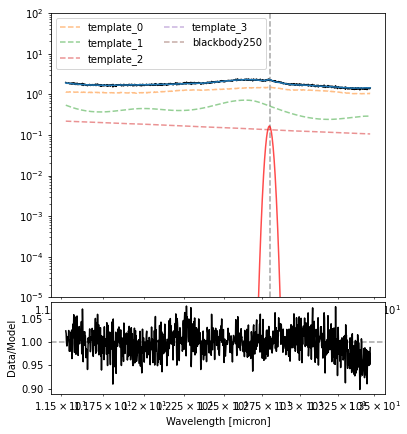

FITSPEC: Line fit took 0.9 s.
FITLOOP: Second call to FITSPEC
1.0
1
FITSPEC: Continuum fit took 0.1 s.
[[Model]]
    Model(manygauss, prefix='lbNeIIrb12pt81_0_')
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 7
    # data points      = 906
    # variables        = 3
    chi-square         = 520786.258
    reduced chi-square = 576.728968
    Akaike info crit   = 5762.77444
    Bayesian info crit = 5777.20156
[[Variables]]
    lbNeIIrb12pt81_0_flx:        0.16271927 +/- 0.02016804 (12.39%) (init = 0.1642202)
    lbNeIIrb12pt81_0_cwv:        12.7955007 +/- 0.00217630 (0.02%) (init = 12.79569)
    lbNeIIrb12pt81_0_sig:        362.354399 +/- 50.7491903 (14.01%) (init = 375.8139)
    lbNeIIrb12pt81_0_srsigslam:  0 (fixed)
Plotting


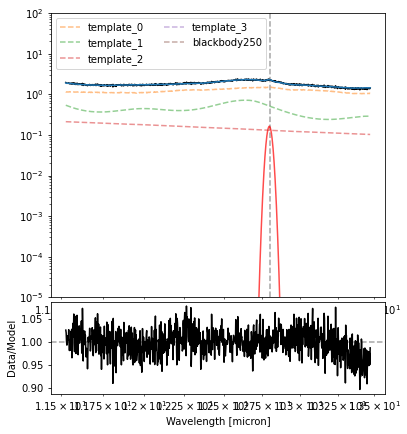

FITSPEC: Line fit took 0.8 s.


In [15]:
q3df(initproc, cols=cols, rows=rows, quiet=False)

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

# <font color='red'> This is currently not yet working. </font>

In [16]:
#import matplotlib
#matplotlib.use('Qt5Agg')
#q3da(initproc, cols=cols, rows=rows, quiet=False)

In [ ]:
%matplotlib